# Canny edge detector from scratch


In [1]:
from __future__ import print_function
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import math
from scipy.ndimage import gaussian_filter
%matplotlib inline

Let's work on a mountain photo !

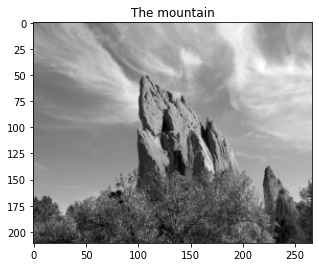

In [2]:
img   = cv2.imread('mountains.png')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

scale_percent = 30 
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
img_resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

plt.figure(figsize=(5,5));
plt.title("The mountain");
plt.imshow(img_resized,cmap='gray');

## 1. The Bilateral Filter

### Custom Gaussian filtering

First of all, I wanted to implement my own gaussian-filtering function. Let's do so :

In [3]:
def g(x,sigma):
    return (1/math.sqrt(2*math.pi*sigma*sigma))*math.exp(-x/(2*sigma*sigma))

def GaussianFiltering(img,sigma,filter_size):
    
    filter_center = math.ceil(filter_size/2)

    
    ## Let's first padd the image correctly
    padd_to_add = math.floor(filter_size/2) ## number of row to add
    img_height = img.shape[0]
    img_width = img.shape[1]    
    padding = np.zeros((img_height+2*padd_to_add,img_width+2*padd_to_add))
    padding[padd_to_add:img_height+padd_to_add,padd_to_add:img_width+padd_to_add] =img
    padded_img = padding
    
    ## Let's create the kernel
    
    filter_distance_matrix=[]
    gauss_matrix=[]
    for i in range(1,filter_size+1):
        resline_distance=[]
        resline_gauss=[]
        for j in range(1,filter_size+1):
            res_distance= (filter_center-i)**2+(filter_center-j)**2
            res_gauss = g(res_distance,sigma)
            
            resline_gauss.append(res_gauss)
            resline_distance.append(res_distance)
            
        filter_distance_matrix.append(resline_distance)
        gauss_matrix.append(resline_gauss)
    
    gauss_matrix=np.array(gauss_matrix)
    gauss_matrix=gauss_matrix/(gauss_matrix.sum())
 
   
    ## Let's filter the image
    
    imgG=[]
    for i in range (padd_to_add,padded_img.shape[0]-padd_to_add):
        resline=[]
        for j in range (padd_to_add,padded_img.shape[1]-padd_to_add):
            res=0
            h2=0
            k2=0
            for k1 in range(int(i-(filter_size-1)/2),int(i+(filter_size-1)/2)+1):
                h2=0
                for h1 in range(int(j-(filter_size-1)/2),int(j+(filter_size-1)/2)+1):
                    
                    Iq = padded_img[k1][h1]
                    res= res+ Iq * gauss_matrix[k2][h2]
                
                   
                    h2+=1
                k2+=1
            resline.append(res)
        imgG.append(resline)
    return(np.array(imgG))

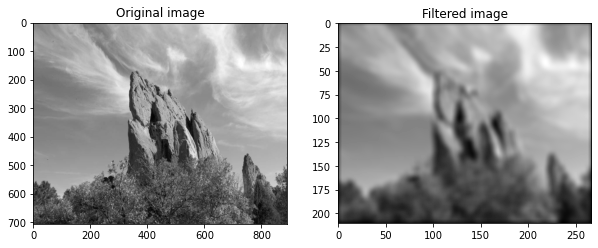

In [4]:
imgG = GaussianFiltering(img_resized,sigma=3,filter_size=9)

plt.figure(figsize=(10,10))
plt.subplot(1,2,2)
plt.imshow(imgG,cmap='gray');
plt.title("Filtered image");
plt.subplot(1,2,1)
plt.title("Original image");
plt.imshow(img,cmap='gray');

This function is efficient in term of filtering, but has a verry poor time of execution. The reason why the scipy implementation is faster is that the Gaussian filtering is parallelized along both axis as the transformation is separable.

The drawback of my custom implementation is then the computational time preventing it from using too large filters.

## Bilateral smoothing

Now let's implement a bilateral filtering

In [5]:
def g(x,sigma):
    return (1/math.sqrt(2*math.pi*sigma*sigma))*math.exp(-x/(2*sigma*sigma))

def g2(x,sigma):
    return (1/math.sqrt(2*math.pi*sigma*sigma))*math.exp(-x*x/(2*sigma*sigma))


def bilateral_filtering(img,sigma,filter_size):
    gaussImg=[]  
    filter_center = math.ceil(filter_size/2)
  
    ## Let's first padd the image correctly
    
    padd_to_add = math.floor(filter_size/2) 
    img_height = img.shape[0]
    img_width = img.shape[1]
    padding = np.zeros((img_height+2*padd_to_add,img_width+2*padd_to_add))
    padding[padd_to_add:img_height+padd_to_add,padd_to_add:img_width+padd_to_add] =img
    padded_img = padding
    
    ## Let's create the kernel
    
    filter_distance_matrix=[]
    gauss_matrix=[]
    for i in range(1,filter_size+1):
        resline_distance=[]
        resline_gauss=[]
        for j in range(1,filter_size+1):
            res_distance= (filter_center-i)**2+(filter_center-j)**2
            res_gauss = g(res_distance,sigma)
            
            resline_gauss.append(res_gauss)
            resline_distance.append(res_distance)
        filter_distance_matrix.append(resline_distance)
        gauss_matrix.append(resline_gauss)
    gauss_matrix=np.array(gauss_matrix)
    gauss_matrix=gauss_matrix/(gauss_matrix.sum())
    
    ## Let's filter the image
    
    imgB=[]
    for i in range (padd_to_add,padded_img.shape[0]-padd_to_add):
        resline=[]
        for j in range (padd_to_add,padded_img.shape[1]-padd_to_add):
            res=0
            Wp=0
            h2=0
            k2=0
            Ip = padded_img[i][j]
            for k1 in range(int(i-(filter_size-1)/2),int(i+(filter_size-1)/2)+1):
                h2=0
                for h1 in range(int(j-(filter_size-1)/2),int(j+(filter_size-1)/2)+1):
                    Iq = padded_img[k1][h1]
                    res +=  Iq * gauss_matrix[k2][h2] *g((Ip/255)**2 - (Iq/255)**2,1)
                    Wp += gauss_matrix[k2][h2]*g((Ip/255)**2 - (Iq/255)**2,1)
                    h2+=1
                k2+=1
            resline.append(res/Wp)
        imgB.append(resline)
    return(np.array(imgB))

Text(0.5, 1.0, 'Bilateral filtering - 5 neighbours')

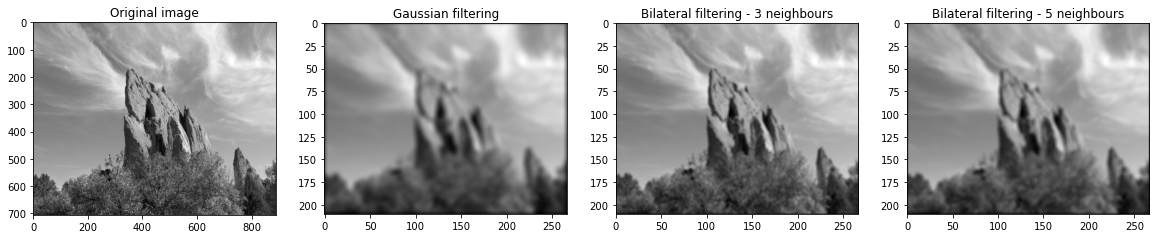

In [6]:
imgB3 = bilateral_filtering(img_resized,sigma=3,filter_size=3)
imgB5 = bilateral_filtering(img_resized,sigma=3,filter_size=5)

plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(img,cmap='gray')
plt.title("Original image")

plt.subplot(1,4,2)
plt.imshow(imgG,cmap='gray')
plt.title("Gaussian filtering")


plt.subplot(1,4,3)
plt.imshow(imgB3,cmap='gray')
plt.title("Bilateral filtering - 3 neighbours")

plt.subplot(1,4,4)
plt.imshow(imgB5,cmap='gray')
plt.title("Bilateral filtering - 5 neighbours")




Here we clearly can see the advantage of using a Bilateral smoothing over Gaussian smoothing. Indeed the Gaussian smoothing blurs all the image and destroy edges information. On the other hand, bilateral smoothing tries to preserve edges information and blurs only plain parts of the image. 

We also note that the bigger the kernel is, the blurier the image and the edges are.

## 2. The Canny edge detector 



For computational reasons, let's use the scipy implementation of Gaussian smoothing.

In [7]:
def gaussian_smoothing(img,sigma):
    img_gaus = gaussian_filter(img,sigma)
    return (img_gaus)

We use Sobel's kernel to compute the gradient along both axis, and then compute magnitude & direction

In [8]:
def gradient(img):
    kernel_sobel_x =np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    kernel_sobel_y =np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    
    sobel_x = convolve2d(img/255,kernel_sobel_x)
    sobel_y = convolve2d(img/255,kernel_sobel_y)
    
    magnitude= np.sqrt(sobel_x**2+sobel_y**2)
    direction = (np.arctan(sobel_y/(sobel_x+0.0001)))+(math.pi/2)
    
    return(magnitude,direction)

Let's visualize the output of this function

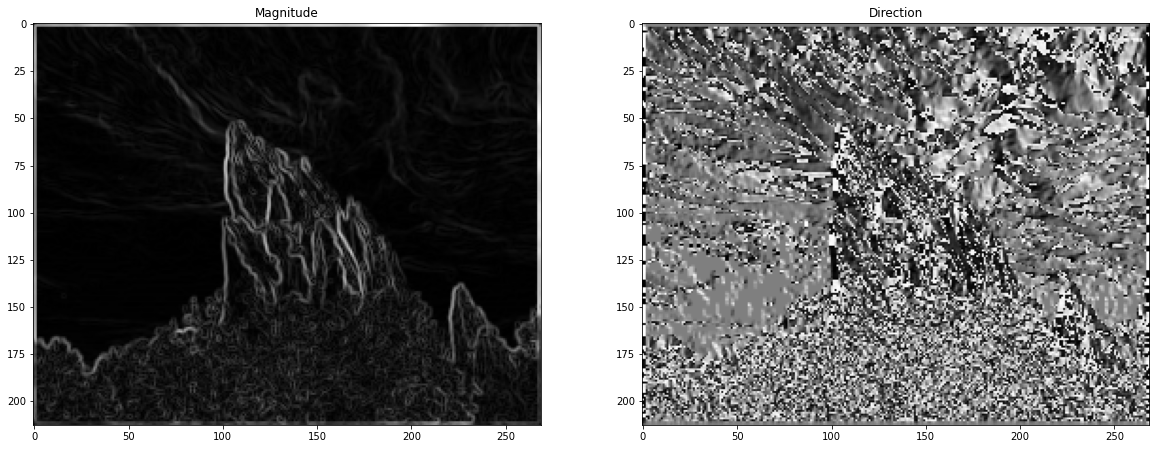

In [9]:
gradient_ = gradient(img_resized)


plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.title("Magnitude")
plt.imshow(gradient_[0],cmap='gray')
plt.subplot(1,2,2)
plt.title("Direction")
plt.imshow(gradient_[1],cmap='gray')

We note that we already have a good idea of the location of edges with the magnitude information, but we can do better. We are going to keep only the most significant gradients. To do so, let's first quantitize or direction into four groups

In [10]:
def quantitizer(direction):


    direction_1  = np.array([direction<(math.pi/8)]).astype(int)
    direction_1 =direction_1*(0)


    direction_2 = np.array([(direction<3*math.pi/8) & (direction>=(math.pi/8))])
    direction_2 =direction_2*(math.pi/4)



    direction_3 = np.array([(direction<5*math.pi/8) & (direction>=(3*math.pi/8))])
    direction_3 =direction_3*(math.pi/2)

    direction_4 = np.array([(direction<7*math.pi/8) & (direction>=(5*math.pi/8))])
    direction_4 =direction_4*(3*math.pi/4)



    direction_5 = np.array([(direction>=(7*math.pi/8))])
    direction_5 =direction_5*0


    direction_final = direction_1+direction_2+direction_3+direction_4+direction_5

    direction_final=np.array(direction_final)[0]

    return(direction_final)

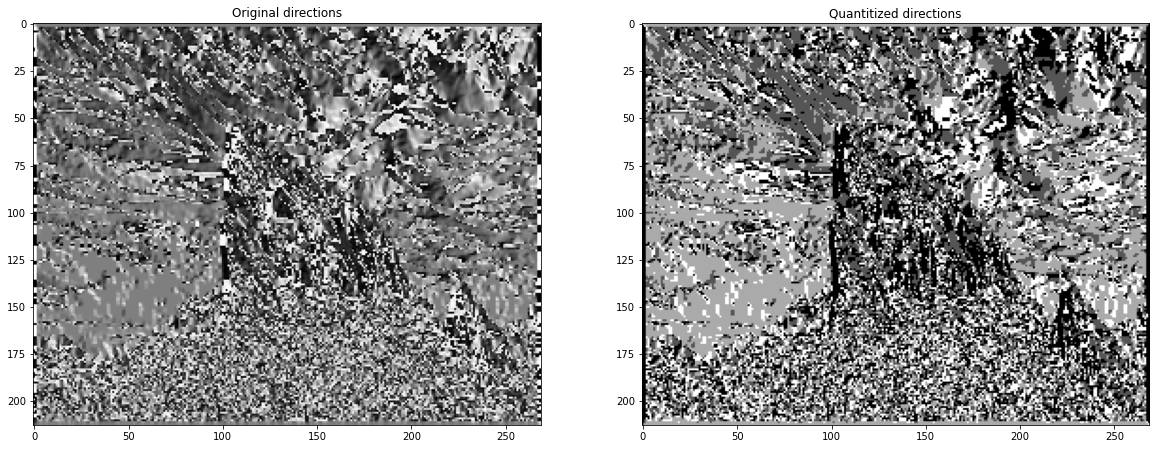

In [11]:
gradient_ = gradient(img_resized)
direction = gradient_[1]
direction_final = quantitizer(direction)

plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.title("Original directions")
plt.imshow(direction,cmap='gray')

plt.subplot(1,2,2)
plt.title("Quantitized directions")
plt.imshow(direction_final,cmap='gray')

Now that have quantitized direction, we can remove gradients with low information compared to his neighbours in the perpendicular direction.

In [12]:
def non_maximum_suppression(g_magnitude, g_dir):
    
    new_g_magnitude = np.copy(g_magnitude)
    
    shape = g_dir.shape
    
    for i in range (1, shape[0]-1):
        for j in range (1, shape[1]-1):
            x=0
            y=0
            direction = g_dir[i][j]
            
            
            if(direction==0):
                x1=0
                y1=1
                x2=0
                y2=-1
            elif(direction==math.pi/4):
                x1=1
                y1=-1
                x2=-1
                y2=1
            elif(direction==math.pi/2):
                x1=-1
                y1=0
                x2=1
                y2=0
            elif(direction==3*math.pi/4):
                x1=1
                y1=1
                x2=-1
                y2=-1
            else:
                print('ERROR')
            
            neigh1= g_magnitude[i+x1][j+y1]
            neigh2= g_magnitude[i+x2][j+y2]
            mag = g_magnitude[i][j]
           
            if(neigh1 >= mag or neigh2>=mag):
             
                new_g_magnitude[i][j]=0
    return(new_g_magnitude)

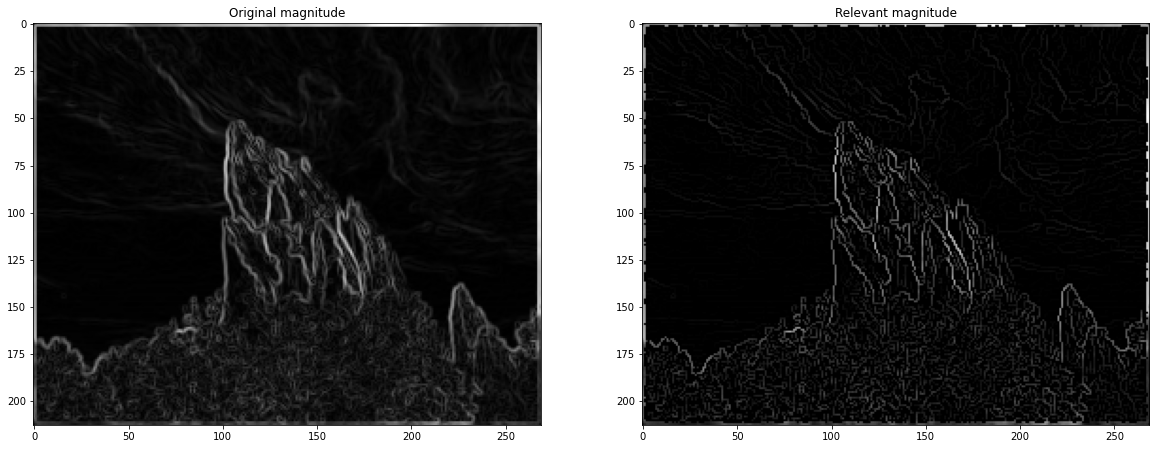

In [13]:
gradient_ = gradient(img_resized)
magnitude = gradient_[0]
direction = gradient_[1]
direction_final = quantitizer(direction)
new_magnitude = non_maximum_suppression(magnitude, direction_final)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title("Original magnitude")
plt.imshow(magnitude,cmap='gray')

plt.subplot(1,2,2)
plt.title("Relevant magnitude")
plt.imshow(new_magnitude,cmap='gray')

Let's double-threshold (high&low) this new magnitude

In [14]:
def double_thresholding(mag,thresh_lo, thresh_hi):
    new_mag = np.copy(mag)
    max_grad = mag.max()
    low_trheshold = max_grad*thresh_lo
    high_trheshold = max_grad*thresh_hi
    shape= mag.shape
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            magij = mag[i][j]
            if(magij<low_trheshold):
                new_mag[i][j]=0
            elif((magij<high_trheshold) and (magij>=low_trheshold)):
                new_mag[i][j]=1
            else:
                new_mag[i][j]=2
    return( new_mag)

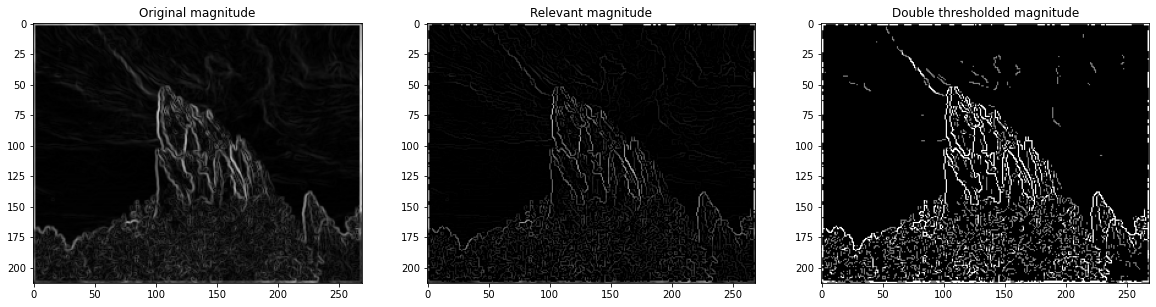

In [15]:
gradient_ = gradient(img_resized)
magnitude = gradient_[0]
direction = gradient_[1]
direction_final = quantitizer(direction)
new_magnitude = non_maximum_suppression(magnitude, direction_final)
double_trhesholded_magnitude = double_thresholding(new_magnitude,0.1, 0.2)

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title("Original magnitude")
plt.imshow(magnitude,cmap='gray')

plt.subplot(1,3,2)
plt.title("Relevant magnitude")
plt.imshow(new_magnitude,cmap='gray')

plt.subplot(1,3,3)
plt.title("Double thresholded magnitude")
plt.imshow(double_trhesholded_magnitude,cmap='gray')

Lastly we can connect the edges

In [16]:
def connect_edge(mag):
    new_mag = np.copy(mag)*0
    shape= new_mag.shape
    for i in range (1, shape[0]-1):
        for j in range (1, shape[1]-1):
            if(mag[i][j]==2):
                new_mag[i][j]=1
            if(mag[i][j]==0):
                new_mag[i][j]=0
            else:
                n1=mag[i-1][j-1]
                n2=mag[i][j-1]
                n3=mag[i+1][j-1]
                n4=mag[i-1][j]
                n5=mag[i+1][j]
                n6=mag[i-1][j+1]
                n7=mag[i][j+1]
                n8=mag[i+1][j+1]
                
                if( n1==2 or n2==2 or n3==2 or n4==2 or n5==2 or n6==2 or n8==2 ):
                    new_mag[i][j]=1
                else:
                    new_mag[i][j]=0
    return new_mag

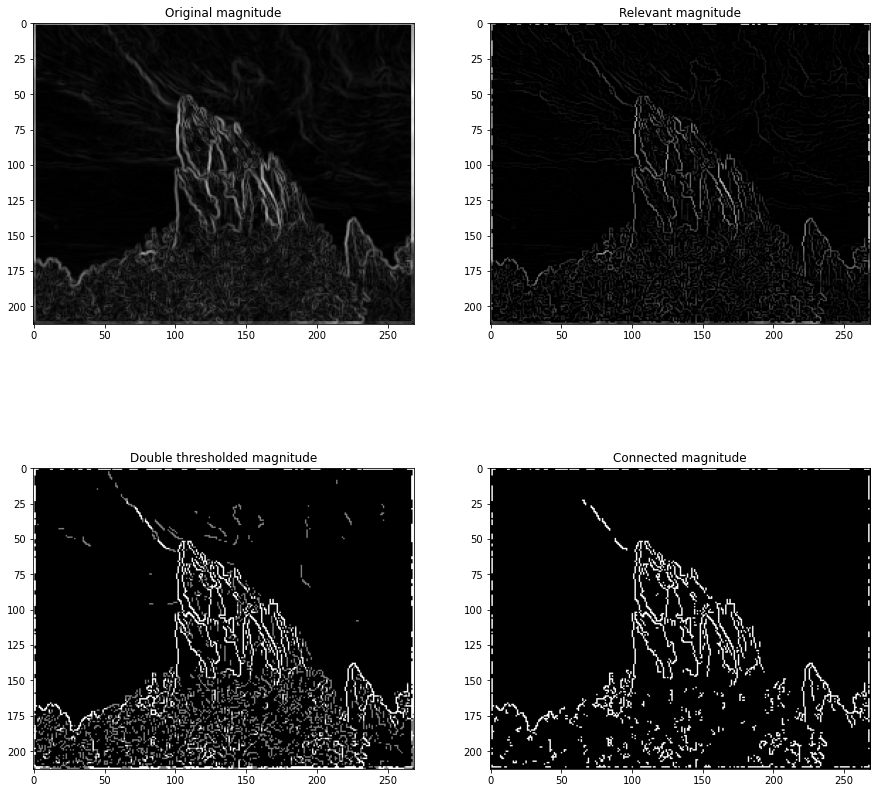

In [17]:
gradient_ = gradient(img_resized)
magnitude = gradient_[0]
direction = gradient_[1]
direction_final = quantitizer(direction)
new_magnitude = non_maximum_suppression(magnitude, direction_final)
double_trhesholded_magnitude = double_thresholding(new_magnitude,0.1, 0.2)
connected_magnitude = connect_edge(double_trhesholded_magnitude)

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title("Original magnitude")
plt.imshow(magnitude,cmap='gray')

plt.subplot(2,2,2)
plt.title("Relevant magnitude")
plt.imshow(new_magnitude,cmap='gray')

plt.subplot(2,2,3)
plt.title("Double thresholded magnitude")
plt.imshow(double_trhesholded_magnitude,cmap='gray')

plt.subplot(2,2,4)
plt.title("Connected magnitude")
plt.imshow(connected_magnitude,cmap='gray')

In [18]:
def canny_edge_detector(img,sigma, thresh_lo=0.1, thresh_hi=0.2,smoothing_type='gauss'):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    ##1 
    if(smoothing_type=="gauss"):
        filtered_img= gaussian_smoothing(img,sigma)
    else:
        filtered_img= bilateral_filtering(img,sigma,3)
    ##2
    (mag,direction)= gradient(filtered_img)
    ##3_1
    direction=quantitizer(direction)
    ##3_1
    mag=non_maximum_suppression(mag, direction)
    ##4 
    mag = double_thresholding(mag,thresh_lo,thresh_hi)
    ##5
    mag = connect_edge(mag)    
    return mag

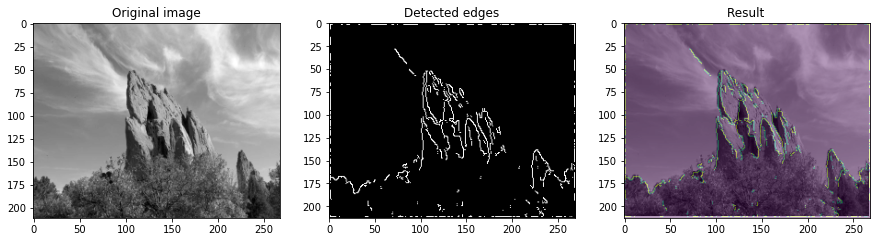

In [19]:
edges = canny_edge_detector(img_resized,0.6, thresh_lo=0.1, thresh_hi=0.2,smoothing_type='gauss')

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title("Original image")
plt.imshow(img_resized,cmap='gray')

plt.subplot(1,3,2)
plt.title("Detected edges")
plt.imshow(edges,cmap='gray')

plt.subplot(1,3,3)
plt.title("Result ")
plt.imshow(img_resized,cmap='gray')
plt.imshow(edges,alpha=0.4)

Let's see the influence of the sigma parameter on the result


Text(0.5, 1.0, 'SIGMA = 2')

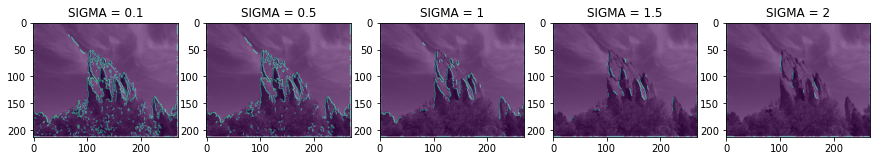

In [20]:
edge_1_gauss = canny_edge_detector(img_resized,sigma=0.1,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='gauss')
edge_2_gauss = canny_edge_detector(img_resized,sigma=0.5,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='gauss')
edge_3_gauss = canny_edge_detector(img_resized,sigma=1,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='gauss')
edge_4_gauss = canny_edge_detector(img_resized,sigma=1.5,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='gauss')
edge_5_gauss = canny_edge_detector(img_resized,sigma=2,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='gauss')

plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_1_gauss,alpha=0.6)
plt.title('SIGMA = 0.1')

plt.subplot(1,5,2)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_2_gauss,alpha=0.6)
plt.title('SIGMA = 0.5')

plt.subplot(1,5,3)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_3_gauss,alpha=0.6)
plt.title('SIGMA = 1')

plt.subplot(1,5,4)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_4_gauss,alpha=0.6)
plt.title('SIGMA = 1.5')

plt.subplot(1,5,5)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_5_gauss,alpha=0.6)
plt.title('SIGMA = 2')

We note that as expected the more the image is smoothed the more information is lost. 

If we want to capture strong edges we should set sigma to a high value. On the contrary to capture small detail, we should set sigma to a low value

We saw that gaussian smoothing delete the edges information. It would be interesting to try a bilateral smoothing instead of gaussian smoothing 

Text(0.5, 1.0, 'SIGMA = 2 - Bi. smoothing')

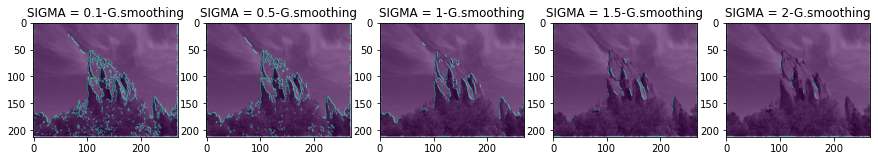

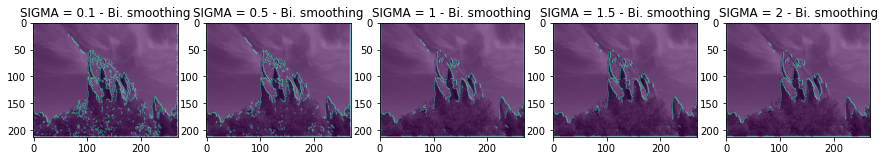

In [21]:
edge_1_bi = canny_edge_detector(img_resized,sigma=0.1,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='bi')
edge_2_bi = canny_edge_detector(img_resized,sigma=0.5,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='bi')
edge_3_bi = canny_edge_detector(img_resized,sigma=1,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='bi')
edge_4_bi = canny_edge_detector(img_resized,sigma=1.5,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='bi')
edge_5_bi = canny_edge_detector(img_resized,sigma=2,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='bi')

plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_1_gauss,alpha=0.6)
plt.title('SIGMA = 0.1-G.smoothing')

plt.subplot(1,5,2)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_2_gauss,alpha=0.6)
plt.title('SIGMA = 0.5-G.smoothing')

plt.subplot(1,5,3)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_3_gauss,alpha=0.6)
plt.title('SIGMA = 1-G.smoothing')

plt.subplot(1,5,4)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_4_gauss,alpha=0.6)
plt.title('SIGMA = 1.5-G.smoothing')

plt.subplot(1,5,5)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_5_gauss,alpha=0.6)
plt.title('SIGMA = 2-G.smoothing')

plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_1_bi,alpha=0.6)
plt.title('SIGMA = 0.1 - Bi. smoothing')

plt.subplot(1,5,2)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_2_bi,alpha=0.6)
plt.title('SIGMA = 0.5 - Bi. smoothing')

plt.subplot(1,5,3)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_3_bi,alpha=0.6)
plt.title('SIGMA = 1 - Bi. smoothing')

plt.subplot(1,5,4)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_4_bi,alpha=0.6)
plt.title('SIGMA = 1.5 - Bi. smoothing')

plt.subplot(1,5,5)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_5_bi,alpha=0.6)
plt.title('SIGMA = 2 - Bi. smoothing')

We note that with bilateral smoothing we can more smooth the image and still preserve edges. Indeed with simga =2 the gaussian filtering remove all edges information whereas the bilateral smoothing still provide good information